# Basic regression: Predict fuel efficiency

Adapted from:

https://www.tensorflow.org/tutorials/keras/regression

In a *regression* problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This tutorial uses the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset and demonstrates how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. To do this, you will provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders, displacement, horsepower, and weight.

This example uses the Keras API. (Visit the Keras [tutorials](https://www.tensorflow.org/tutorials/keras) and [guides](https://www.tensorflow.org/guide/keras) to learn more.)

In [4]:
import pandas as pd
import numpy as np
import operator
import seaborn as sns
import matplotlib.pyplot as plt

# Configure the matlotlib backend as plotting inline in IPython:
%matplotlib inline

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import random

In [5]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

print(tf.__version__)

2.10.0


* Some tensorflow-built-in functions:
* for classification problems use:
`from tensorflow.keras.utils import to_categorical`
* for regression problems use:
`from tensorflow.keras.utils import to_ordinal`

In [6]:
print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices('GPU'))


[]


## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


### Get the data
* First download and import the dataset using `pandas`:

In [7]:
# the url address: 
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
# a more neat naming of the columns:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
# now convert to a DataFrame:
raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [8]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


#### Get the data from a csv file locally:
* Read the dataset using pandas:
```python
data = pd.read_csv('myDataSets/auto-mpg.csv', index_col='car name')
data.tail()
```

### Clean the data

The dataset contains a few unknown values:

In [9]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

* there are six null values in the Horsepower column

* drop those rows 

In [10]:
dataset = dataset.dropna()# Drop null values

### Convert categorical features into one hot encoding

`sklearn.preprocessing.OneHotEncoder`

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

* Encode categorical features as a one-hot numeric array.
* The input to this transformer should be an array-like of integers or strings, denoting the values taken on by categorical (discrete) features.

In [11]:
dataset['Origin_Name'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,Origin_Name
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,USA
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,Europe
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,USA
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,USA
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,USA


In [12]:
dataset.info()# Get an overview of the dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
 8   Origin_Name   392 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 30.6+ KB


In [13]:
from sklearn.preprocessing import OneHotEncoder

* with ordinal categories:
```python
ohe = OneHotEncoder()

transformed = ohe.fit_transform(dataset[['Origin']])

print(transformed.toarray()[random.sample(range(0, 150), 5)])

print(ohe.categories_)
```

In [14]:
# with nominal categories:
ohe = OneHotEncoder()

In [15]:
transformed = ohe.fit_transform(dataset[['Origin_Name']])

In [96]:
type(transformed)

scipy.sparse._csr.csr_matrix

In [16]:
print(transformed.toarray()[random.sample(range(0, 150), 5)])

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [17]:
print(ohe.categories_)

[array(['Europe', 'Japan', 'USA'], dtype=object)]


In [18]:
dataset[ohe.categories_[0]] = transformed.toarray()

dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,Origin_Name,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,USA,0.0,0.0,1.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,USA,0.0,0.0,1.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,USA,0.0,0.0,1.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,USA,0.0,0.0,1.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,USA,0.0,0.0,1.0


In [19]:
data = dataset.copy()

data.drop(['Origin', 'Origin_Name'], axis=1, inplace=True)

data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0.0,0.0,1.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,0.0,0.0,1.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,0.0,0.0,1.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,0.0,0.0,1.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,0.0,0.0,1.0


#### Convert categorical features into one hot encoding using `get_dummies`

* The `"Origin"` column is categorical, not numeric.
* So the next step is to one-hot encode the values in the column with [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

* Note: You can set up the `tf.keras.Model` to do this kind of transformation for you but that's beyond the scope of this tutorial. Check out the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) or [Load CSV data](../load_data/csv.ipynb) tutorials for examples.

```python
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()
```

### Split the data into training and test sets


In [20]:
from sklearn.model_selection import train_test_split

In [21]:
# The data is split into training and testing sets:
train_dataset, test_dataset = train_test_split(data, 
                                               test_size = 0.25
                                              )

In [22]:
train_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
41,14.0,8,318.0,150.0,4096.0,13.0,71,0.0,0.0,1.0
51,30.0,4,79.0,70.0,2074.0,19.5,71,1.0,0.0,0.0
122,24.0,4,121.0,110.0,2660.0,14.0,73,1.0,0.0,0.0
380,36.0,4,120.0,88.0,2160.0,14.5,82,0.0,1.0,0.0
253,20.5,6,200.0,95.0,3155.0,18.2,78,0.0,0.0,1.0


In [23]:
test_dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
123,20.0,6,156.0,122.0,2807.0,13.5,73,0.0,1.0,0.0
192,22.0,6,250.0,105.0,3353.0,14.5,76,0.0,0.0,1.0
157,15.0,8,350.0,145.0,4440.0,14.0,75,0.0,0.0,1.0
250,19.4,8,318.0,140.0,3735.0,13.2,78,0.0,0.0,1.0
276,21.6,4,121.0,115.0,2795.0,15.7,78,1.0,0.0,0.0


### Another way to split the DataFrame into training and testing sets:

```python
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
```

### Inspect the data

* Review the joint distribution of a few pairs of columns from the training set.

* The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters.

* The other rows indicate they are functions of each other.

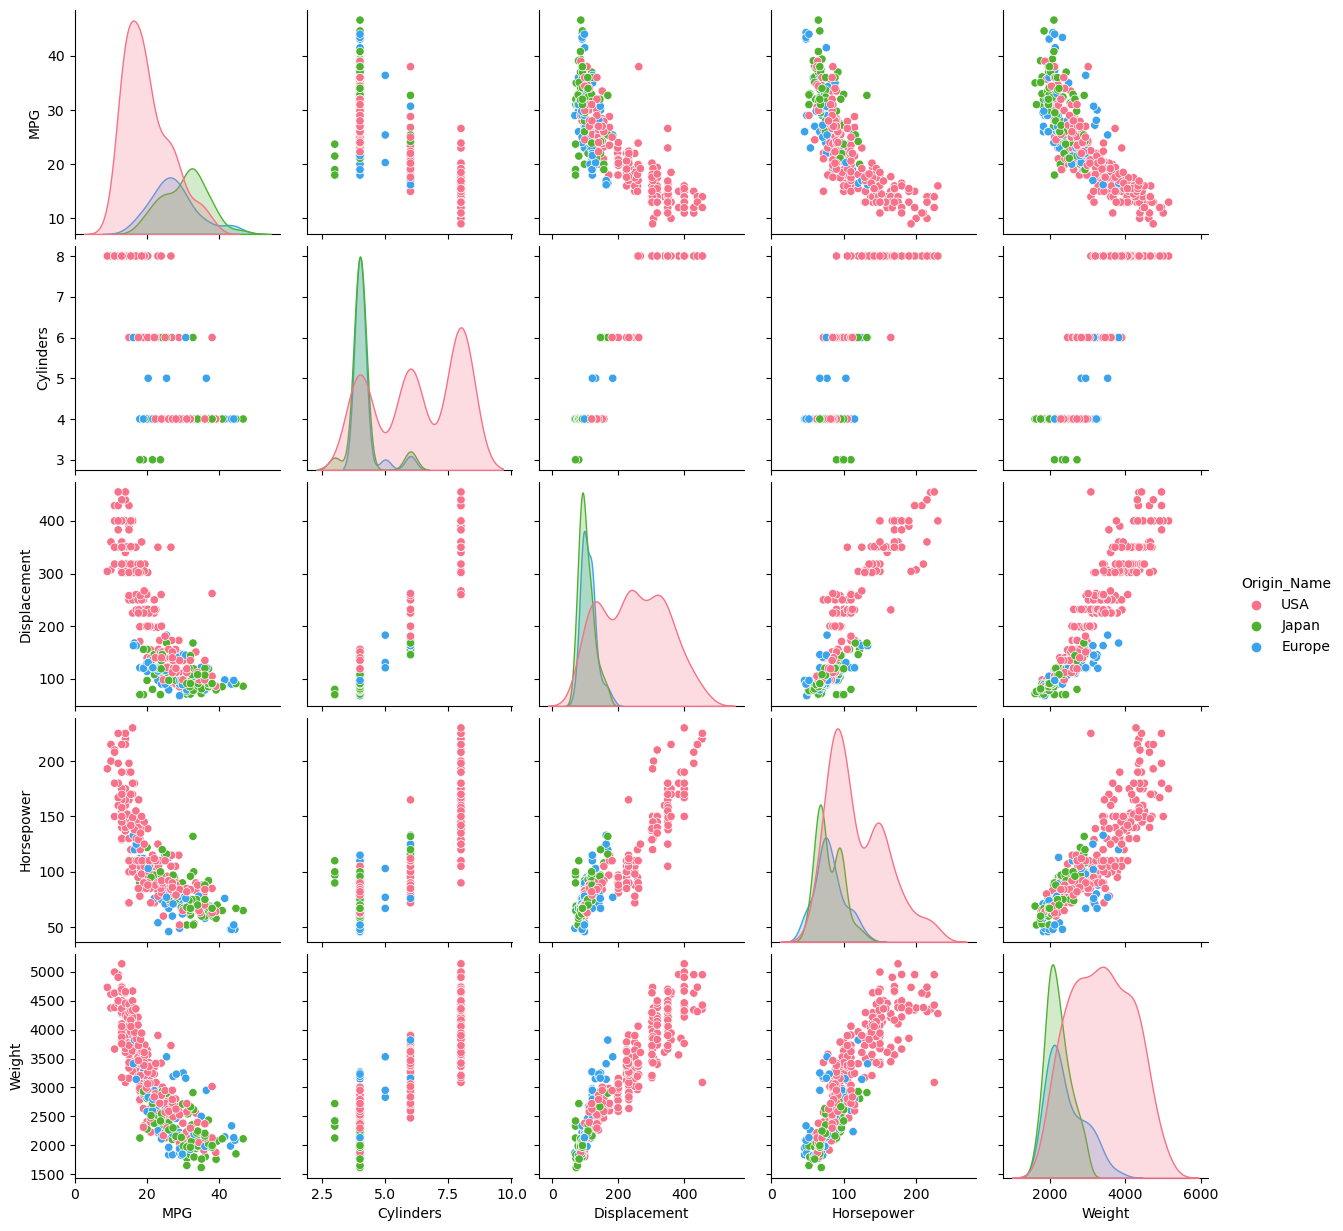

In [24]:
sns.pairplot(dataset[['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Origin_Name']], 
             hue='Origin_Name', 
             diag_kind='kde',
             palette='husl')

* Let's also check the overall statistics.
* Note how each feature covers a very different range:

In [25]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,294.0,23.790816,7.931250,9.0,17.500,23.35,29.725,46.6
Cylinders,294.0,5.391156,1.703256,3.0,4.000,4.00,7.500,8.0
Displacement,294.0,191.501701,106.360377,68.0,98.000,140.50,260.000,455.0
Horsepower,294.0,103.132653,38.877063,46.0,75.000,90.00,120.000,225.0
Weight,294.0,2951.513605,855.721075,1613.0,2219.250,2742.50,3568.250,5140.0
Acceleration,294.0,15.597619,2.785499,8.0,13.625,15.50,17.300,24.8
Model Year,294.0,75.918367,3.765317,70.0,73.000,76.00,79.000,82.0
Europe,294.0,0.170068,0.376333,0.0,0.000,0.00,0.000,1.0
Japan,294.0,0.214286,0.411026,0.0,0.000,0.00,0.000,1.0
USA,294.0,0.615646,0.487272,0.0,0.000,1.00,1.000,1.0


### Split features from labels

* Separate the target value—the "label"—from the features.
* This label is the value that you will train the model to predict.

In [26]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

In [27]:
test_features.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
50,28.0,4,116.0,90.0,2123.0,14.0,71,1.0,0.0,0.0
325,44.3,4,90.0,48.0,2085.0,21.7,80,1.0,0.0,0.0
120,19.0,4,121.0,112.0,2868.0,15.5,73,1.0,0.0,0.0
226,20.5,6,231.0,105.0,3425.0,16.9,77,0.0,0.0,1.0
107,18.0,6,232.0,100.0,2789.0,15.0,73,0.0,0.0,1.0


### Magic!
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pop.html

In [28]:
train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [29]:
test_features.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
50,4,116.0,90.0,2123.0,14.0,71,1.0,0.0,0.0
325,4,90.0,48.0,2085.0,21.7,80,1.0,0.0,0.0
120,4,121.0,112.0,2868.0,15.5,73,1.0,0.0,0.0
226,6,231.0,105.0,3425.0,16.9,77,0.0,0.0,1.0
107,6,232.0,100.0,2789.0,15.0,73,0.0,0.0,1.0


In [30]:
train_features.columns

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'Europe', 'Japan', 'USA'],
      dtype='object')

In [31]:
test_features.Cylinders.unique()

array([4, 6, 8], dtype=int64)

In [32]:
name_features = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Europe', 'Japan', 'USA']

In [33]:
name_features_num = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration']

In [34]:
test_labels.values[random.sample(range(0, len(test_labels)), 5)]

array([28. , 25. , 26.6, 32. , 23.9])

## Normalization

* In the table of statistics it's easy to see how different the ranges of each feature are:

In [35]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.790816,7.931250
Cylinders,5.391156,1.703256
Displacement,191.501701,106.360377
Horsepower,103.132653,38.877063
Weight,2951.513605,855.721075
Acceleration,15.597619,2.785499
Model Year,75.918367,3.765317
Europe,0.170068,0.376333
Japan,0.214286,0.411026
USA,0.615646,0.487272


* It is good practice to normalize features that use different scales and ranges.

* One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

* Although a model *might* converge without feature normalization, normalization makes training much more stable.

* Note: There is no advantage to normalizing the one-hot features—it is done here for simplicity. For more details on how to use the preprocessing layers, refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial.

In [36]:
from sklearn.preprocessing import StandardScaler

# Scale data to have mean 0 and variance 1 
# This is importance for convergence of the neural network
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(train_features)
X_test = standard_scaler.fit_transform(test_features)

In [37]:
X_train[0,:]

array([ 1.534,  1.191,  1.208,  1.34 , -0.934, -1.308, -0.453, -0.522,
        0.79 ])

In [38]:
type(X_train), type(X_test), X_train.shape, X_test.shape

(numpy.ndarray, numpy.ndarray, (294, 9), (98, 9))

In [39]:
Y_train = train_labels.values
Y_test = test_labels.values
type(Y_train), type(Y_test), Y_train.shape, Y_test.shape

(numpy.ndarray, numpy.ndarray, (294,), (98,))

In [40]:
X_train.shape[1]

9

In [41]:
Y_train[random.sample(range(0, len(Y_train)), 5)]

array([34. , 13. , 37.2, 15. , 27. ])

### Another way to normalize and put them back into a dataframe:
```python
scaler = StandardScaler()
scaler.fit(train_features[name_features])
scaled = scaler.fit_transform(train_features[name_features])
scaled_df = pd.DataFrame(scaled, columns=train_features[name_features].columns)
```

## Building a ANN with the Functional API

In [42]:
X_train.shape

(294, 9)

In [43]:
input_shape = X_train.shape[1:]
inputs = keras.Input(shape=input_shape)

In [44]:
F1 = layers.Dense(units=8, 
                  activation='relu', 
                  kernel_initializer='random_normal'
                 )(inputs)

In [45]:
F2 = layers.Dense(units=32, 
                  activation='relu', 
                  kernel_initializer='random_normal'
                 )(F1)

In [46]:
F3 = layers.Dense(units=16, 
                  activation='relu', 
                  kernel_initializer='random_normal'
                 )(F2)

In [47]:
F34 = layers.Dense(units=6,
                   activation='relu',
                   kernel_initializer='random_normal'
                  )(F3)

In [48]:
F24 = layers.Dense(units=5,
                   activation='relu',
                   kernel_initializer='random_normal'
                  )(F2)

In [49]:
F14 = layers.Dense(units=5,
                   activation='relu',
                   kernel_initializer='random_normal'
                  )(F1)

In [50]:
F4 = layers.Concatenate()([F34, F24, F14])

In [51]:
F4 = layers.Dense(units=16,
                   activation='relu',
                   kernel_initializer='random_normal'
                  )(F4)

In [52]:
outputs = layers.Dense(1)(F4)

In [53]:
modelS = keras.Model(inputs=inputs, outputs=outputs)

In [54]:
modelS.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 8)            80          ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 32)           288         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 16)           528         ['dense_1[0][0]']                
                                                                                              

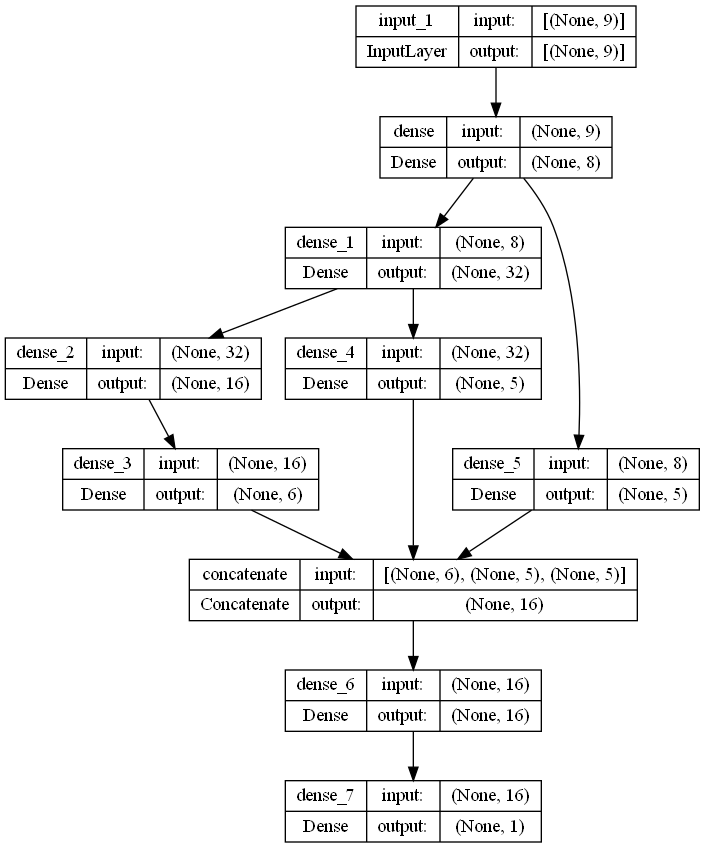

In [55]:
plot_model(modelS, to_file="model_MPG_api.png", show_shapes=True)

### CAUTION: For MacOS users only:
**WARNING:** absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.

**WARNING:** absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.

In [97]:
opt = tf.keras.optimizers.Adam(learning_rate=0.1) # can delete ".legacy" (in between .optimizers and .Adam) if not on mac
modelS.compile(optimizer=opt,
               loss='mean_absolute_error', 
               metrics=['accuracy', 'mse', 'mae']
              )

In [57]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

In [58]:
modelS_history = modelS.fit(X_train, Y_train,
                            batch_size=5, 
                            epochs=1000, 
                            verbose=1,
                            validation_split = 0.2,
                            callbacks=[early_stop]
                           )

Epoch 1/1000
47/47 [==============================] - 3s 21ms/step - loss: 7.8140 - accuracy: 0.0000e+00 - mse: 111.8223 - mae: 7.8140 - val_loss: 6.8301 - val_accuracy: 0.0000e+00 - val_mse: 74.2114 - val_mae: 6.8301
Epoch 2/1000
47/47 [==============================] - 0s 6ms/step - loss: 3.8600 - accuracy: 0.0000e+00 - mse: 27.1062 - mae: 3.8600 - val_loss: 3.9764 - val_accuracy: 0.0000e+00 - val_mse: 30.1155 - val_mae: 3.9764
Epoch 3/1000
47/47 [==============================] - 0s 5ms/step - loss: 3.3893 - accuracy: 0.0000e+00 - mse: 20.7076 - mae: 3.3893 - val_loss: 2.6769 - val_accuracy: 0.0000e+00 - val_mse: 10.9349 - val_mae: 2.6769
Epoch 4/1000
47/47 [==============================] - 0s 6ms/step - loss: 3.1868 - accuracy: 0.0000e+00 - mse: 18.4021 - mae: 3.1868 - val_loss: 2.4385 - val_accuracy: 0.0000e+00 - val_mse: 10.5227 - val_mae: 2.4385
Epoch 5/1000
47/47 [==============================] - 0s 5ms/step - loss: 3.3334 - accuracy: 0.0000e+00 - mse: 20.1801 - mae: 3.3334 -

Text(0.5, 0, 'Epochs')

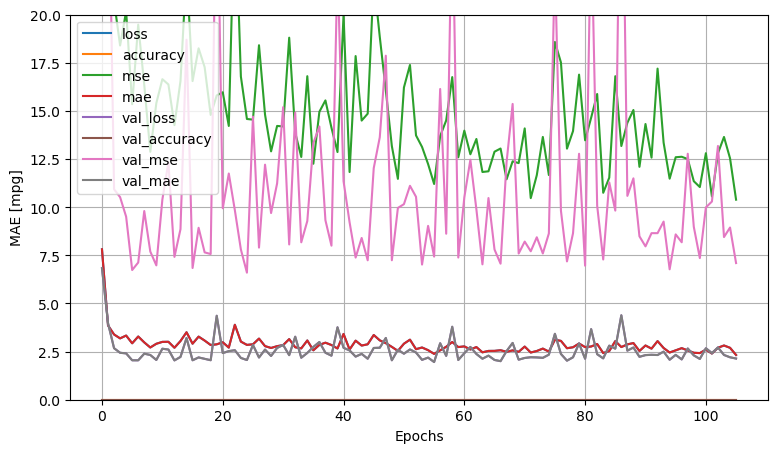

In [59]:
pd.DataFrame(modelS_history.history).plot(figsize=(9, 5))
plt.grid(True)
plt.gca().set_ylim(0, 20) # set the vertical range to [0-1] plt.show()
plt.ylabel('MAE [mpg]')
plt.xlabel('Epochs')

In [60]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 20])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

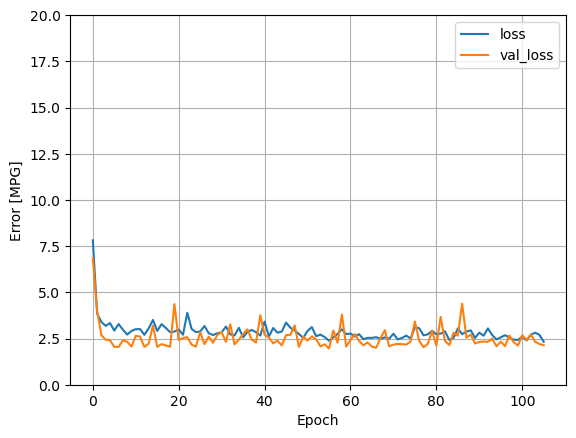

In [61]:
plot_loss(modelS_history)

In [62]:
test_preds = modelS.predict(X_test).flatten()

4/4 [==============================] - 0s 3ms/step


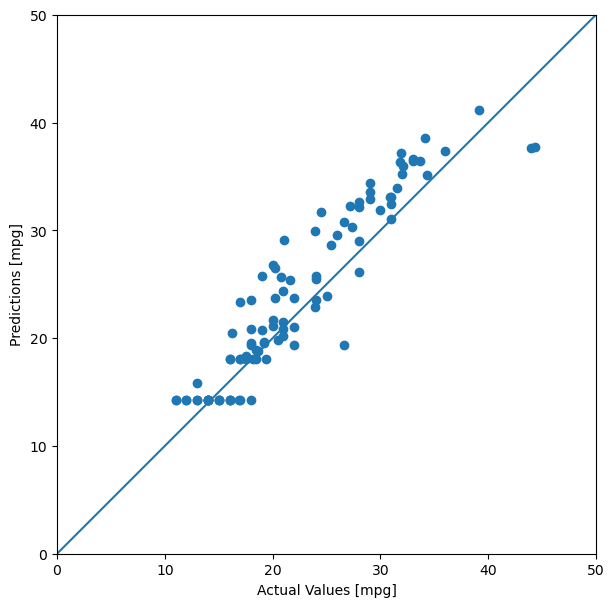

In [63]:
figP, axP = plt.subplots(1, figsize=(7,7))
#evaluation_plot = plt.axes(aspect='equal')
axP.scatter(Y_test, test_preds)#Scatter Plot
axP.set_ylabel('Predictions [mpg]')#Y for Predictions
axP.set_xlabel('Actual Values [mpg]')#X for Actual Values
axP.set_xlim([0, 50])
axP.set_ylim([0, 50])
axP.plot([0, 50], [0, 50]) #line plot for comparison
axP.set_aspect('equal')

In [64]:
loss, accuracy, mse, mae = modelS.evaluate(X_test, Y_test,
                                           verbose=2
                                          )
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("Testing set Mean Squared Error: {:5.2f} MPG".format(mse))
print("Testing set Loss Error: {:5.2f} MPG".format(loss))

4/4 - 0s - loss: 2.5747 - accuracy: 0.0000e+00 - mse: 10.6625 - mae: 2.5747 - 69ms/epoch - 17ms/step
Testing set Mean Abs Error:  2.57 MPG
Testing set Mean Squared Error: 10.66 MPG
Testing set Loss Error:  2.57 MPG


## Linear regression - Sequential Format

Build the Keras Sequential model.

Look for examples in the documentation:

https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

In [65]:
model = Sequential()

In [66]:
[X_train.shape[1]]

[9]

### FIRST hidden layer in the network

In [67]:
model.add(Dense(units=8, 
                activation='relu', 
                kernel_initializer='random_normal',
                input_shape=[X_train.shape[1]]
               )
         )

### SECOND hidden layer in the network

In [68]:
model.add(Dense(units=32, 
                activation='relu', 
                kernel_initializer='random_normal'
               )
         )

### THIRD hidden layer in the network

In [69]:
model.add(Dense(units=16, 
                activation='relu', 
                kernel_initializer='random_normal'
               )
         )

### OUTPUT layer in the network

* The output layer must have only one neuron since this is a regression case

In [70]:
model.add(Dense(units=1))

#### Display the flowchart of model

```python
tf.keras.utils.plot_model(model, show_shapes=True)
```

In [71]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 8)                 80        
                                                                 
 dense_9 (Dense)             (None, 32)                288       
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 913
Trainable params: 913
Non-trainable params: 0
_________________________________________________________________


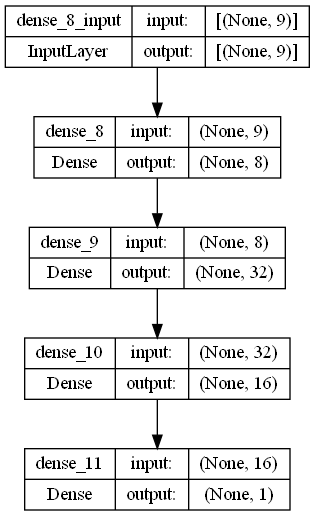

In [72]:
plot_model(model, to_file="model_MPG_seq.png", show_shapes=True)

In [73]:
32*8, 16*32

(256, 512)

## Model Configuration

* Once the model is built, configure the training procedure using the Keras `Model.compile` method. 
* The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized (`mean_absolute_error`) and how (using the `tf.keras.optimizers.Adam`).

```python
model.compile(optimizer='adam', #  sgd
              loss='mse', 
              metrics=['mse', 'mae']
             )
```

In [74]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.1)
model.compile(optimizer=opt,
              loss='mean_absolute_error', 
              metrics=['accuracy', 'mse', 'mae']
             )

### Early Stop Configuration

In [75]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

In [76]:
X_train.shape, Y_train.shape

((294, 9), (294,))

Use Keras `Model.fit` to execute the training for 100 epochs:

In [77]:
model_history = model.fit(X_train, Y_train,
                          batch_size=5, 
                          epochs=1000, 
                          verbose=1,
                          # Calculate validation results on 20% of the training data:
                          validation_split = 0.2,
                          callbacks=[early_stop]
                         )

Epoch 1/1000
47/47 [==============================] - 2s 14ms/step - loss: 6.7830 - accuracy: 0.0000e+00 - mse: 105.5759 - mae: 6.7830 - val_loss: 3.9757 - val_accuracy: 0.0000e+00 - val_mse: 25.0335 - val_mae: 3.9757
Epoch 2/1000
47/47 [==============================] - 0s 5ms/step - loss: 4.2993 - accuracy: 0.0000e+00 - mse: 34.6544 - mae: 4.2993 - val_loss: 2.9312 - val_accuracy: 0.0000e+00 - val_mse: 13.6415 - val_mae: 2.9312
Epoch 3/1000
47/47 [==============================] - 0s 5ms/step - loss: 4.7289 - accuracy: 0.0000e+00 - mse: 38.8170 - mae: 4.7289 - val_loss: 5.6338 - val_accuracy: 0.0000e+00 - val_mse: 46.5509 - val_mae: 5.6338
Epoch 4/1000
47/47 [==============================] - 0s 4ms/step - loss: 4.4584 - accuracy: 0.0000e+00 - mse: 33.0711 - mae: 4.4584 - val_loss: 4.1288 - val_accuracy: 0.0000e+00 - val_mse: 29.5376 - val_mae: 4.1288
Epoch 5/1000
47/47 [==============================] - 0s 5ms/step - loss: 3.6669 - accuracy: 0.0000e+00 - mse: 23.6606 - mae: 3.6669 -

This model will predict `'MPG'` from `'Horsepower'`.

Run the untrained model on the first 10 'Horsepower' values. The output won't be good, but notice that it has the expected shape of `(10, 1)`:

In [78]:
model.layers[0].kernel

<tf.Variable 'dense_8/kernel:0' shape=(9, 8) dtype=float32, numpy=
array([[ 2.512,  0.475,  0.709,  0.291,  0.843,  0.639, -1.392,  1.051],
       [ 5.142,  0.15 ,  0.069, -0.043, -1.638,  0.151,  1.704, -0.071],
       [-1.149, -0.062, -0.395, -0.317, -2.098, -0.016,  6.04 , -1.088],
       [-3.014, -0.32 , -0.475, -0.579, -5.023, -0.083,  5.389, -0.547],
       [ 2.973,  0.107,  0.279, -0.119, -1.014,  0.092,  0.132, -1.506],
       [ 4.026,  0.904,  0.447, -0.054,  2.863,  0.929, -3.215, -0.038],
       [ 2.133,  0.034, -0.103, -0.138, -0.428, -0.296,  0.324, -0.177],
       [-0.669,  0.201,  0.065,  0.247,  0.659,  0.707,  1.146,  0.231],
       [-1.125,  0.055,  0.074,  0.22 , -0.104,  0.274, -0.925,  0.03 ]],
      dtype=float32)>

In [79]:
model.layers[1].kernel

<tf.Variable 'dense_9/kernel:0' shape=(8, 32) dtype=float32, numpy=
array([[ 1.148, -0.056, -0.029, -0.078, -0.224, -0.602, -0.593, -0.168,
        -0.286, -0.147, -0.182, -0.559, -0.367, -0.568, -0.146, -0.083,
        -0.571, -0.58 , -0.664, -0.207, -0.   , -0.602, -0.314, -0.2  ,
        -0.28 , -0.029,  0.117,  0.021, -0.317, -0.306, -1.956, -0.257],
       [-0.839, -1.155, -0.674, -0.031, -0.932,  0.006,  0.033, -0.121,
        -0.119, -0.041, -0.107, -0.044,  0.147, -0.592, -0.59 , -0.03 ,
        -0.494, -0.505, -0.039, -0.058,  0.038, -0.053,  0.214, -0.043,
         0.313, -0.572, -0.634,  0.035, -0.101, -0.137,  0.323,  0.04 ],
       [ 0.258, -0.007, -0.051, -0.417, -0.32 , -0.509, -0.52 , -0.206,
        -0.22 , -0.216, -0.245, -0.577, -0.513, -0.056,  0.015, -0.098,
        -0.615, -0.576, -0.005, -0.236, -0.319, -0.561, -0.391, -0.26 ,
        -0.686, -0.044,  0.129, -0.238, -0.252, -0.114, -0.98 , -0.152],
       [ 0.121, -0.905, -0.537, -0.009, -0.401, -0.575, -0.096,  

In [80]:
model.layers[2].kernel

<tf.Variable 'dense_10/kernel:0' shape=(32, 16) dtype=float32, numpy=
array([[-2.694, -0.539, -0.68 , -0.594, -1.55 ,  0.923, -0.567, -0.058,
        -0.008, -0.576, -0.718, -0.526, -0.059, -0.625, -0.684, -0.8  ],
       [-0.107, -0.543, -0.705, -0.521,  0.007,  0.019, -0.571, -4.216,
        -1.837, -0.591, -0.445, -0.597,  1.616,  0.047, -0.652, -0.199],
       [-0.006, -0.5  , -0.578, -0.615, -0.034,  0.58 , -0.512,  0.053,
        -0.024, -0.553, -0.511, -0.522, -0.001,  0.591, -0.623, -0.024],
       [-0.602, -0.637, -0.61 , -0.606, -0.42 ,  0.41 , -0.547, -0.337,
        -0.004, -0.661, -0.627, -0.588, -0.684, -0.441, -0.551, -0.265],
       [-0.252, -0.576, -0.552, -0.549, -0.201,  0.054, -0.527, -0.779,
        -0.032, -0.604, -0.718, -0.69 , -1.522, -0.093, -0.653, -0.123],
       [ 0.651,  0.008, -0.693, -0.56 ,  0.678, -0.003, -0.516,  0.039,
         0.022, -0.556, -0.554, -0.519, -0.028,  0.616, -0.486, -0.118],
       [ 0.693,  0.027,  0.01 , -0.521,  0.737,  0.023, -0.5

In [81]:
model.layers[3].kernel

<tf.Variable 'dense_11/kernel:0' shape=(16, 1) dtype=float32, numpy=
array([[-0.664],
       [ 0.332],
       [ 0.327],
       [ 0.173],
       [-0.538],
       [ 1.021],
       [ 0.43 ],
       [ 0.   ],
       [ 1.272],
       [ 0.116],
       [ 0.167],
       [ 0.402],
       [-0.265],
       [-0.348],
       [ 0.133],
       [ 0.   ]], dtype=float32)>

In [82]:
output = model.layers[3]

In [83]:
output.name

'dense_11'

In [84]:
weights, biases = output.get_weights()

In [85]:
model.metrics_names

['loss', 'accuracy', 'mse', 'mae']

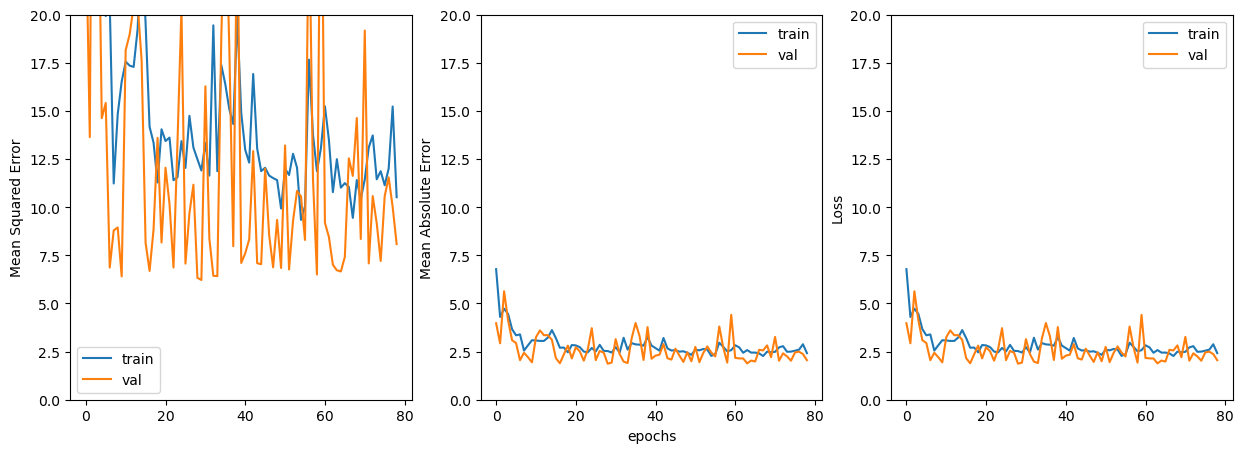

In [86]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(model_history.history['mse'], label='train')
ax1.plot(model_history.history['val_mse'], label='val')
ax2.plot(model_history.history['mae'], label='train')
ax2.plot(model_history.history['val_mae'], label='val')
ax3.plot(model_history.history['loss'], label='train')
ax3.plot(model_history.history['val_loss'], label='val')

ax1.set_ylabel('Mean Squared Error')
ax2.set_ylabel('Mean Absolute Error')
ax3.set_ylabel('Loss')
ax2.set_xlabel('epochs')
ax1.set_ylim([0, 20])
ax2.set_ylim([0, 20])
ax3.set_ylim([0, 20])
ax1.legend()
ax2.legend()
ax3.legend()

Visualize the model's training progress using the stats stored in the `history` object:

Text(0.5, 0, 'Epochs')

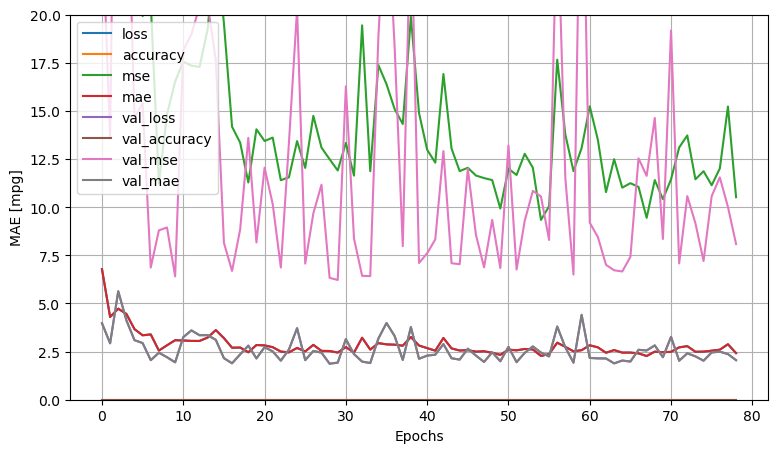

In [87]:
pd.DataFrame(model_history.history).plot(figsize=(9, 5))
plt.grid(True)
plt.gca().set_ylim(0, 20) # set the vertical range to [0-1] plt.show()
plt.ylabel('MAE [mpg]')
plt.xlabel('Epochs')

In [88]:
hist = pd.DataFrame(model_history.history)
hist['epoch'] = model_history.epoch
hist.tail()

,loss,accuracy,mse,mae,val_loss,val_accuracy,val_mse,val_mae,epoch
74,2.498860,0.0,11.872004,2.498860,2.026631,0.0,7.206976,2.026631,74
75,2.547318,0.0,11.140592,2.547318,2.456600,0.0,10.574937,2.456600,75
76,2.598533,0.0,12.010747,2.598533,2.496258,0.0,11.550593,2.496258,76
77,2.881524,0.0,15.232077,2.881524,2.370946,0.0,10.014594,2.370946,77
78,2.420361,0.0,10.520442,2.420361,2.054085,0.0,8.086583,2.054085,78


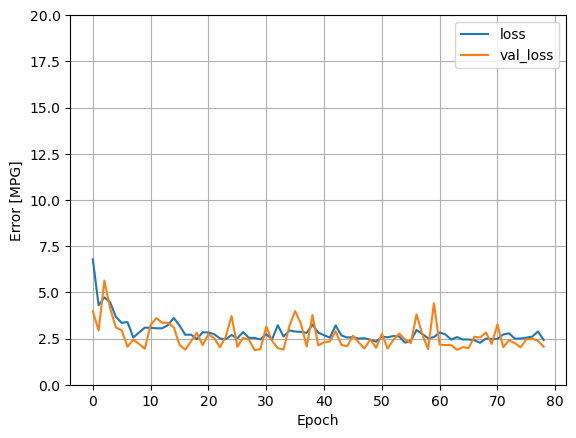

In [89]:
plot_loss(model_history)

### Evaluate the model using test set

In [90]:
model.metrics_names

['loss', 'accuracy', 'mse', 'mae']

In [91]:
loss, accuracy, mse, mae = model.evaluate(X_test,
                                Y_test,
                                verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("Testing set Mean Squared Error: {:5.2f} MPG".format(mse))
print("Testing set Loss Error: {:5.2f} MPG".format(loss))

4/4 - 0s - loss: 1.8278 - accuracy: 0.0000e+00 - mse: 5.4264 - mae: 1.8278 - 70ms/epoch - 17ms/step
Testing set Mean Abs Error:  1.83 MPG
Testing set Mean Squared Error:  5.43 MPG
Testing set Loss Error:  1.83 MPG


### Generate predictions


In [92]:
test_preds = model.predict(X_test).flatten()

4/4 [==============================] - 0s 3ms/step


### Plot the test set labels (actual values) against the predictions generated with the test set features

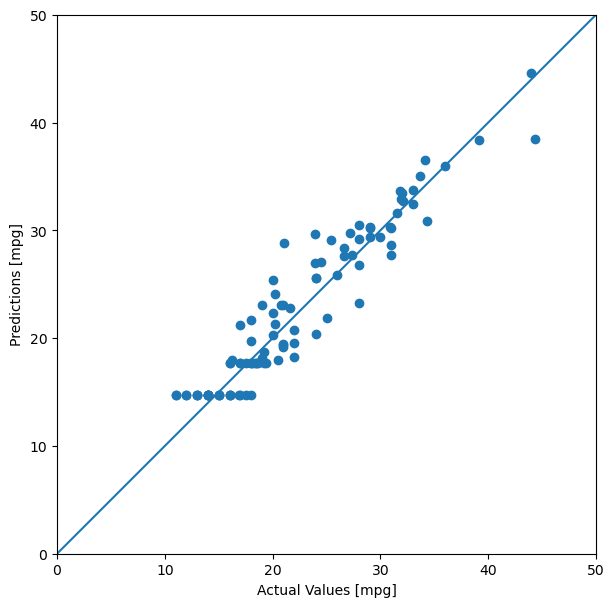

In [93]:
figP, axP = plt.subplots(1, figsize=(7,7))
#evaluation_plot = plt.axes(aspect='equal')
axP.scatter(Y_test, test_preds)#Scatter Plot
axP.set_ylabel('Predictions [mpg]')#Y for Predictions
axP.set_xlabel('Actual Values [mpg]')#X for Actual Values
axP.set_xlim([0, 50])
axP.set_ylim([0, 50])
axP.plot([0, 50], [0, 50]) #line plot for comparison
axP.set_aspect('equal')

### Generate a histogram showing the distribution of error terms around zero

* it is an important indication of bias in our model

Text(0, 0.5, 'Count')

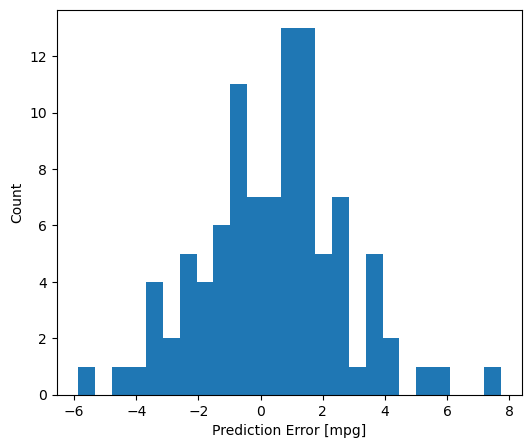

In [94]:
error = test_preds - Y_test
figE, axE = plt.subplots(1, figsize=(6,5))
axE.hist(error, bins = 25)
axE.set_xlabel("Prediction Error [mpg]")
axE.set_ylabel("Count")

In [95]:
%%script false --no-raise-error

UsageError: %%script is a cell magic, but the cell body is empty.


## What to pay attention:

- Mean squared error (MSE) (`tf.keras.losses.MeanSquaredError`) and mean absolute error (MAE) (`tf.keras.losses.MeanAbsoluteError`) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.
- Similarly, evaluation metrics used for regression differ from classification.
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the [Overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.

## Hyperparameter Tuning